In [1]:
import pandas as pd
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from datetime import datetime, timedelta

In [2]:
#Read and rename columns for daily data
daily_data = pd.read_csv('SN_d_tot_V2.0.csv', sep=';' , header=None)
daily_data.columns= ['year', 'month', 'day', 'fractional_year', 'sunspot_number',
    'std_dev', 'observations', 'indicator']


In [3]:
print(daily_data.tail())

       year  month  day  fractional_year  sunspot_number  std_dev  \
74625  2022      4   26         2022.316             132     21.8   
74626  2022      4   27         2022.319             132     14.8   
74627  2022      4   28         2022.322             135     15.5   
74628  2022      4   29         2022.325             107     21.4   
74629  2022      4   30         2022.327              51      8.3   

       observations  indicator  
74625            43          0  
74626            43          0  
74627            42          0  
74628            39          0  
74629            35          0  


In [4]:
#data_preprocessing function to handle the missing values and convert the input format for prophet

def data_preprocessing(data, time_unit):
    #removing missing values -1
    data = data[data['sunspot_number']>=0]
    #convert to datetime
    if(time_unit== 'daily'):
        data['ds'] = pd.to_datetime(data[['year','month','day']])
    elif(time_unit== 'monthly'):
        data['ds'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
    elif(time_unit== 'yearly'):
        #handling float value(mid-year date)
         # Convert fractional year to datetime directly inside this function
        def fractional_year_to_date(year):
            base_year = int(year)
            fraction = year - base_year
            # Approximate the fraction as days (365.25 days for leap year consideration)
            days = int(fraction * 365.25)
            return datetime(base_year, 1, 1) + timedelta(days=days)
        
        #Apply transformation for yearly time unit
        data['ds'] = data['year'].apply(fractional_year_to_date)
    #keep only required columns
    data=data[['ds','sunspot_number']].rename(columns={'sunspot_number':'y'})
    
    return data

In [5]:
daily_clean = data_preprocessing(daily_data, 'daily')
daily_clean.head()

,ds,y
7,1818-01-08,65
12,1818-01-13,37
16,1818-01-17,77
17,1818-01-18,98
18,1818-01-19,105


<Axes: xlabel='ds'>

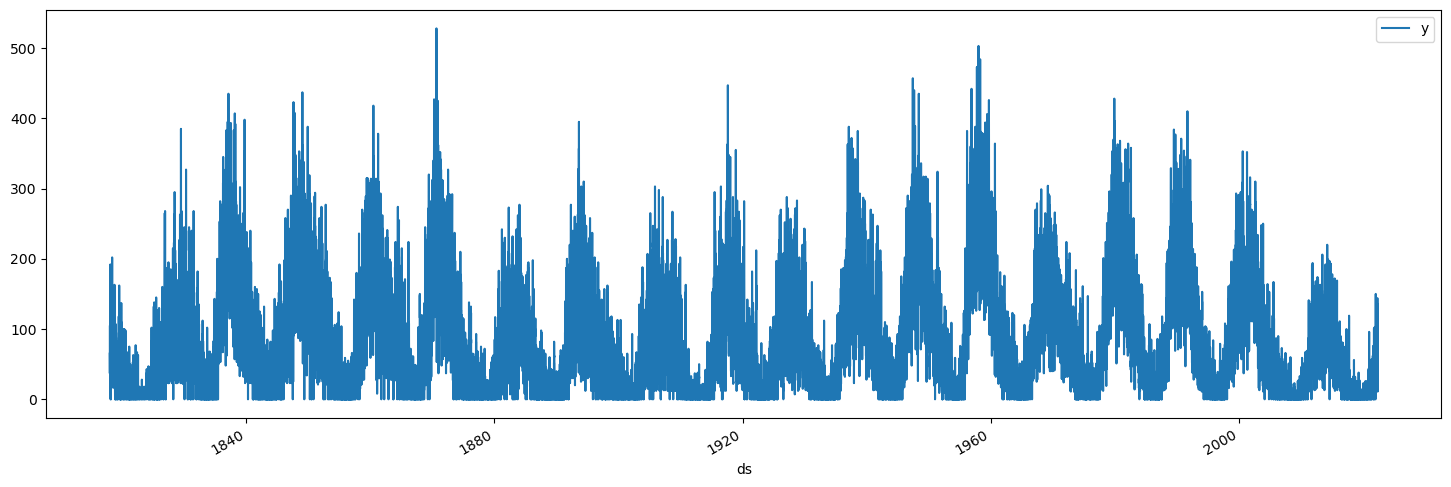

In [6]:
daily_clean.plot(x='ds', y= 'y', figsize=(18,6))

In [7]:
len(daily_clean)

71383

## Train, Test Split

In [9]:
train = daily_clean.iloc[:len(daily_clean)-365]
test = daily_clean.iloc[len(daily_clean)-365:]

## Making Predictions 365 days into the future

16:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing


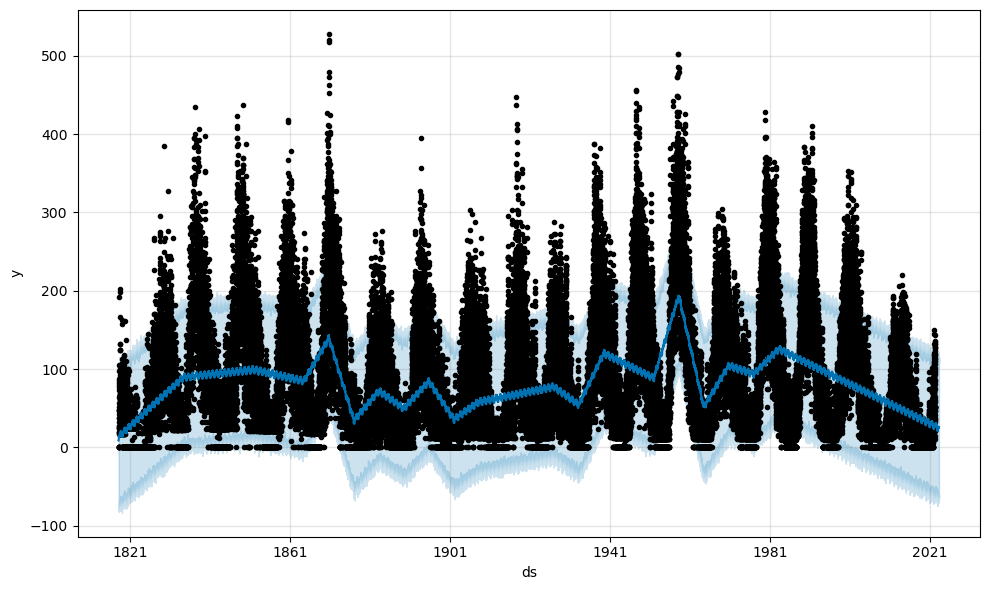

In [11]:
# Initialize Prophet model
model = Prophet()
model.fit(daily_clean)  # Fit the model to the entire dataset

# Create a DataFrame for future predictions
future = model.make_future_dataframe(periods=365)  # Extend 365 days into the future

# Forecast future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

In [12]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
71743,2023-04-26,25.475164,-63.049649,114.241047
71744,2023-04-27,25.530329,-65.857191,112.634986
71745,2023-04-28,25.347246,-58.648609,111.303844
71746,2023-04-29,25.632085,-59.008589,108.943755
71747,2023-04-30,25.698783,-60.612881,115.207883


## Evaluate Predictions_1

In [14]:
# Train the model on training data
model = Prophet()
model.fit(train)

# Create a DataFrame for predictions on the test set
future_test = test[['ds']]  # Use test data dates for prediction
forecast_test = model.predict(future_test)

# Actual values
y_actual = test['y'].values

# Predicted values
y_pred = forecast_test['yhat'].values

# MAE
mae = mean_absolute_error(y_actual, y_pred)

# MAPE (Using Scikit-learn)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100  # Multiply by 100 to express as a percentage

# R² Score
r2 = r2_score(y_actual, y_pred)
# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R² Score: {r2}")

17:00:59 - cmdstanpy - INFO - Chain [1] start processing
17:02:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 30.33857173611225
Mean Absolute Percentage Error (MAPE): 5.152337210588041e+17%
R² Score: -0.5037786011177161


## Making Predictions 365 days into the future with add_seasonality(fourier_order=3)

17:02:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing


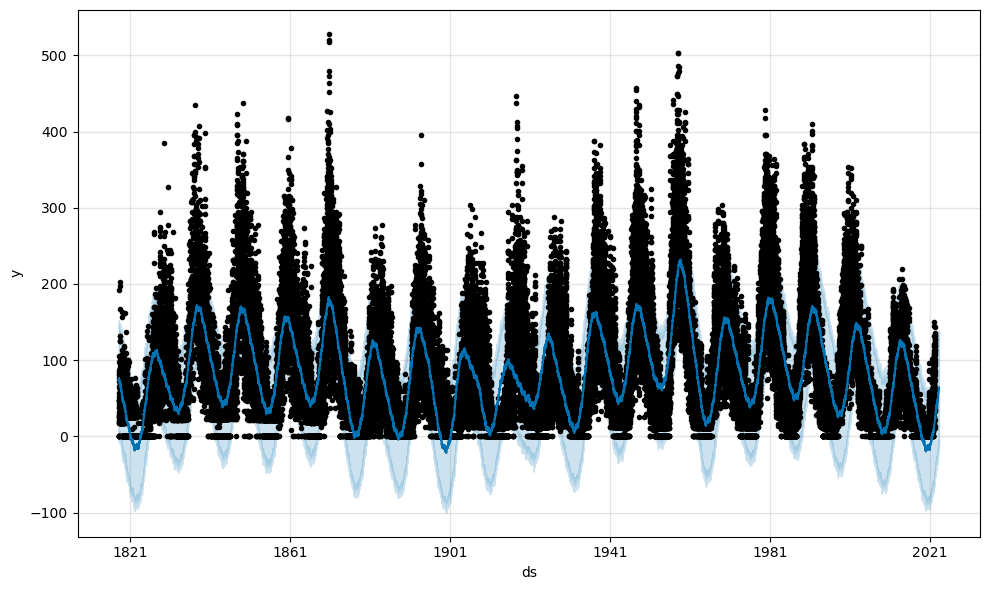

In [16]:
# Initialize the model
model = Prophet()

# Add custom seasonality for the 11-year solar cycle
# 'period' specifies the length of the cycle in days (11 years = 11 * 365.25 days)
# 'fourier_order' controls the complexity of the seasonality (higher values for more flexibility)
model.add_seasonality(name='solar_cycle', period=11*365.25, fourier_order=3)

# Fit the model
model.fit(daily_clean)

# Forecast future dates
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()


## Evaluate Predictions_add_seasonality(3)

17:04:29 - cmdstanpy - INFO - Chain [1] start processing
17:06:06 - cmdstanpy - INFO - Chain [1] done processing


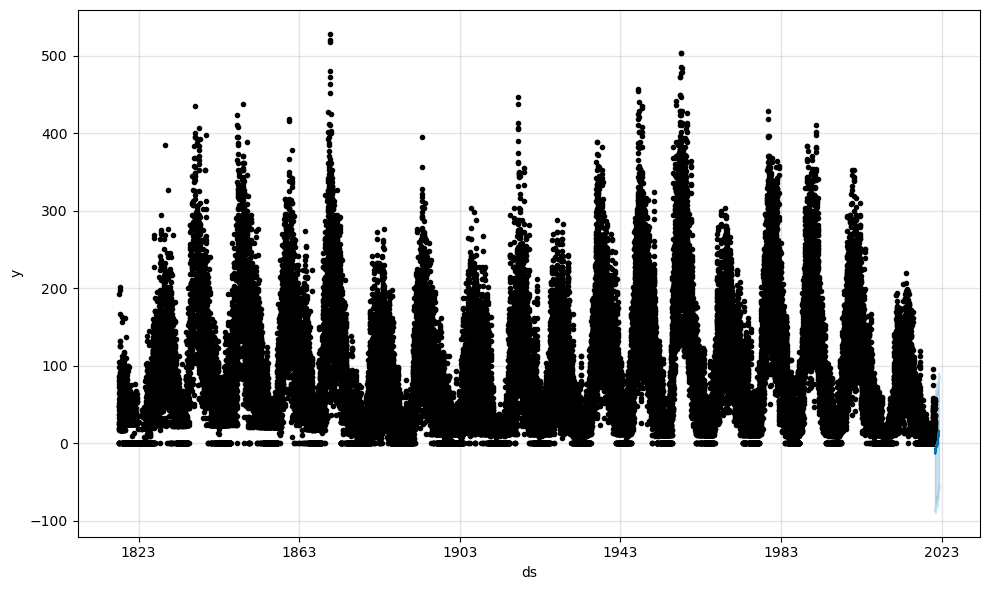

Mean Absolute Error (MAE): 48.17193184288249
Mean Absolute Percentage Error (MAPE): 1.3525039120875437e+17%
R² Score: -1.823884186940111


In [18]:
# Initialize the model
model = Prophet()

# Add custom seasonality for the 11-year solar cycle
# 'period' specifies the length of the cycle in days (11 years = 11 * 365.25 days)
# 'fourier_order' controls the complexity of the seasonality (higher values for more flexibility)
model.add_seasonality(name='solar_cycle', period=11*365.25, fourier_order=3)

# Step 3: Fit the model on the training data
model.fit(train)

# Step 4: Make predictions for the test set
future_test = test[['ds']]  # Use test set dates for prediction
forecast_test = model.predict(future_test)

model.plot(forecast_test)
plt.show()

# Step 5: Extract actual and predicted values
y_actual = test['y'].values  # Actual sunspot counts
y_pred = forecast_test['yhat'].values  # Predicted sunspot counts

# Step 6: Calculate evaluation metrics
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual, y_pred)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100  # Expressed as percentage

# R² Score
r2 = r2_score(y_actual, y_pred)

# Step 7: Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R² Score: {r2}")

## Making Predictions 365 days into the future with add_seasonality(fourier_order=5)

17:06:10 - cmdstanpy - INFO - Chain [1] start processing
17:07:53 - cmdstanpy - INFO - Chain [1] done processing


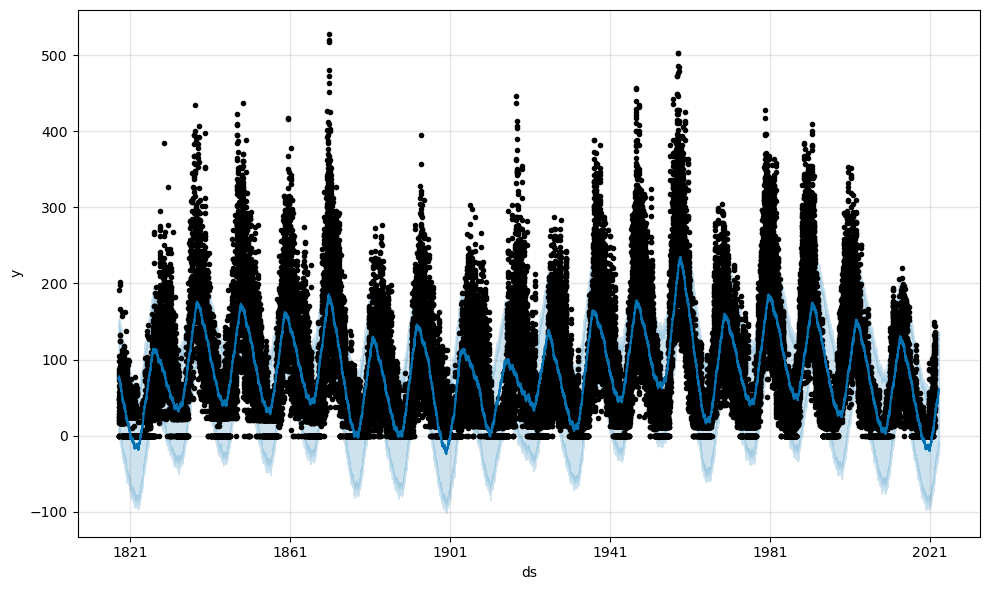

In [20]:
# Initialize the model
model = Prophet()

# Add custom seasonality for the 11-year solar cycle
# 'period' specifies the length of the cycle in days (11 years = 11 * 365.25 days)
# 'fourier_order' controls the complexity of the seasonality (higher values for more flexibility)
model.add_seasonality(name='solar_cycle', period=11*365.25, fourier_order=5)

# Fit the model
model.fit(daily_clean)

# Forecast future dates
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()


## Evaluate Predictions_add_seasonality(5)

In [22]:
# Initialize the model
model = Prophet()

# Add custom seasonality for the 11-year solar cycle
# 'period' specifies the length of the cycle in days (11 years = 11 * 365.25 days)
# 'fourier_order' controls the complexity of the seasonality (higher values for more flexibility)
model.add_seasonality(name='solar_cycle', period=11*365.25, fourier_order=5)

# Step 3: Fit the model on the training data
model.fit(train)

# Step 4: Make predictions for the test set
future_test = test[['ds']]  # Use test set dates for prediction
forecast_test = model.predict(future_test)

# Step 5: Extract actual and predicted values
y_actual = test['y'].values  # Actual sunspot counts
y_pred = forecast_test['yhat'].values  # Predicted sunspot counts

# Step 6: Calculate evaluation metrics
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual, y_pred)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100  # Expressed as percentage

# R² Score
r2 = r2_score(y_actual, y_pred)

# Step 7: Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R² Score: {r2}")

17:08:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 47.43973394314598
Mean Absolute Percentage Error (MAPE): 1.5851333561139942e+17%
R² Score: -1.7220961152244745


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Split the dataset into train and test sets
train = daily_clean.iloc[:-365]  # Use all but the last year for training
test = daily_clean.iloc[-365:]  # Last year for testing

# Function to evaluate predictions
def evaluate_forecast(y_actual, y_pred):
    # Filter out zero values in y_actual to avoid MAPE errors
    non_zero_mask = y_actual != 0
    y_actual_filtered = y_actual[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]
    
    mae = mean_absolute_error(y_actual_filtered, y_pred_filtered)
    mape = np.mean(np.abs((y_actual_filtered - y_pred_filtered) / y_actual_filtered)) * 100
    r2 = r2_score(y_actual_filtered, y_pred_filtered)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    return mae, mape, r2

# Iterate through different parameter combinations
growth_types = ['logistic', 'flat']
changepoint_prior_scales = [0.1, 0.2]
n_changepoints_values = [25, 50]
fourier_orders = [6, 7]

# Initialize variables to store best metrics and configurations
best_mae = float('inf')
best_mape = float('inf')
best_r2 = float('-inf')

best_config_mae = None
best_config_mape = None
best_config_r2 = None

for growth in growth_types:
    for cps in changepoint_prior_scales:
        for n_changepoints in n_changepoints_values:
            for fourier_order in fourier_orders:
                print(f"\nTesting: growth={growth}, cps={cps}, n_changepoints={n_changepoints}, fourier_order={fourier_order}")
                
                # Initialize the model
                model = Prophet(
                    growth=growth,
                    changepoint_prior_scale=cps,
                    n_changepoints=n_changepoints
                )
                
                # Add custom seasonality
                model.add_seasonality(name='solar_cycle', period=11*365.25, fourier_order=fourier_order)
                
                # Add a cap for logistic growth (required if growth='logistic')
                if growth == 'logistic':
                    train['cap'] = 500  # Example cap (modify based on your data)
                    test['cap'] = 500
                
                # Fit the model
                model.fit(train)
                
                # Forecast for test dates
                future = test[['ds']]
                if growth == 'logistic':
                    future['cap'] = 500  # Add cap for future if logistic growth
                
                forecast = model.predict(future)
                
                # Evaluate the forecast
                y_actual = test['y'].values
                y_pred = forecast['yhat'].values
                mae, mape, r2 = evaluate_forecast(y_actual, y_pred)
                
                # Track the best configurations for each metric
                if mae < best_mae:
                    best_mae = mae
                    best_config_mae = (growth, cps, n_changepoints, fourier_order)
                
                if mape < best_mape:
                    best_mape = mape
                    best_config_mape = (growth, cps, n_changepoints, fourier_order)
                
                if r2 > best_r2:  # Higher R² is better
                    best_r2 = r2
                    best_config_r2 = (growth, cps, n_changepoints, fourier_order)

# Print the best configurations
print("\nBest Configuration for MAE:")
print(f"Growth: {best_config_mae[0]}, Changepoint Prior Scale: {best_config_mae[1]}, "
      f"n_changepoints: {best_config_mae[2]}, Fourier Order: {best_config_mae[3]}")
print(f"Best MAE: {best_mae}")

print("\nBest Configuration for MAPE:")
print(f"Growth: {best_config_mape[0]}, Changepoint Prior Scale: {best_config_mape[1]}, "
      f"n_changepoints: {best_config_mape[2]}, Fourier Order: {best_config_mape[3]}")
print(f"Best MAPE: {best_mape:.2f}%")

print("\nBest Configuration for R²:")
print(f"Growth: {best_config_r2[0]}, Changepoint Prior Scale: {best_config_r2[1]}, "
      f"n_changepoints: {best_config_r2[2]}, Fourier Order: {best_config_r2[3]}")
print(f"Best R² Score: {best_r2:.4f}")


Testing: growth=logistic, cps=0.1, n_changepoints=25, fourier_order=6


17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:11:27 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(365)

,ds,yhat,yhat_lower,yhat_upper
0,2021-05-01,-6.111712,-83.560110,65.027587
1,2021-05-02,-6.009458,-83.173358,64.869780
2,2021-05-03,-5.491180,-80.759374,66.590317
3,2021-05-04,-5.493289,-75.597862,67.816842
4,2021-05-05,-5.229472,-81.603971,63.725721
...,...,...,...,...
360,2022-04-26,28.540110,-46.807068,99.869757
361,2022-04-27,28.865922,-47.260134,104.702686
362,2022-04-28,29.231783,-43.554797,105.677622
363,2022-04-29,29.108973,-41.321325,102.273696
